#### This notebook is for explorer options to optimization procedures over budget consumption. 

In [157]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

In [158]:
from utilities import *
from google_cloud import BigQuery, Storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import os
import sys

import boto3
import base64

#Cliente BigQuery
AUTH_BIGQUERY = base64.b64decode(os.environ['SECRET_AUTH_BIGQUERY_MODEL'])
bq = BigQuery(AUTH_BIGQUERY)
storage =Storage(AUTH_BIGQUERY)

# Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [3]:
# !pip install matplotlib
# !pip install pandas -U
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-storage
# !pip install db-dtypes

## Definicion de la funcion update

In [4]:
def daily_consumption(budget:float,
                      eop:str,
                      date:str,
                      Fj:float,
                      verbose = True):
    """Estimacion del consumo diario necesrio para consumir B en los proximos dias del mes.
    budget: Budget for the campain.
    eop: Last day of the campain. Date for 100% of the budget need to be consumed (e.g '2022-04-30')
    date: today.
    Fj: accumulated consumption of the budget until day j (i - 1).
                        fi = (B-F(t=i-1))/(n-i+1)
    ----------------------------
    Output:
    fi: daily consumption estimation for date (today)
    """
     #How manny days left until the budget need to be consumet (n-i+1)
    date = pd.to_datetime(date)
    n = (pd.to_datetime(eop) - date).days
    #predefined daily consumption.
    fi = (budget - Fj)/(n)  
    if verbose:
        print(f'date of consumption: {(date).strftime("%Y-%m-%d")} n(i) = {n}, F(i-1) = {Fj}, f(i) = {fi}')

    return fi

def consumtion_expand(site:str,bop:str,eop:str):
    """ETL for New Buyers consumtion between bop and eop.
    site: site 
    bop: begening of the period of the campaing.
    eop: end of the period for the campaing.
    """
    q = QueryParamatrized(query_ = 'NB_CONSUMTION',
                          query_param = {'bop':bop ,'eop':eop, 'site':site},
                          conf  = conf
                         )
    df = bq.execute_response(q)
    logger.info(f"Size of the dataframe {df.shape}")

    if df.empty: 
        sys.exit(f"Check, no information on consumtion between {bop} and {eop}")

    #CAST
    df['AMOUNT'] = df.AMOUNT.astype(float)
    df['pay_created_dt'] = pd.to_datetime(df.pay_created_dt)
    #TIME EXPAND
    time_series = pd.date_range(start = bop, end = eop,freq = 'D')
    month_seq = pd.DataFrame({'pay_created_dt':time_series})
    #BACKBONE
    df = month_seq.merge(df[['pay_created_dt','AMOUNT']],on = ['pay_created_dt'],how = 'left')
    logger.info(f"Complet the dataframe (id is necessary) - new size: {df.shape}")
    df.AMOUNT.fillna(value = 0, inplace = True)
    df['ACC_AMOUNT'] = df['AMOUNT'].cumsum()
    logger.info(f"Total amount of consumtion is {np.nanmax(df.ACC_AMOUNT)}")
    return df

In [408]:
bop = '2022-04-01'
eop = '2022-04-30'
site = 'MLM'
#We need to call this from somewhere.
budget = 3000000

In [409]:
df = consumtion_expand(site = site, bop = bop,eop = eop)

2022-04-07 07:57:13 Excecuting NB_CONSUMTION with params: {'bop': '2022-04-01', 'eop': '2022-04-30', 'site': 'MLM'}
/usr/local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:445: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "
2022-04-07 07:57:20 Size of the dataframe (4, 3)
2022-04-07 07:57:20 Complet the dataframe (id is necessary) - new size: (30, 2)
2022-04-07 07:57:20 Total amount of consumtion is 224800.0


In [410]:
#some params
N = df.shape[0]
avg_fi = budget/(N)
lim_sup = 3*avg_fi

In [411]:
#Check for the daily consumption for tomorrow.
month_seq = df.pay_created_dt
fi = []
for date in month_seq:
    #Calculations only until date = eop -1
    if date < pd.to_datetime(eop):
        #BOP
        if date == pd.to_datetime(bop):
            F = 0
        else:
            yesterday = date - timedelta(days = 1)
            I = df.pay_created_dt == yesterday
            F =  df.loc[I].ACC_AMOUNT.values[0]
            
        f = daily_consumption(budget = budget,
                              eop = eop,
                              date = date,
                              Fj = F,
                              verbose = False)
        fi.append(f)
    #EOP dont need estimation.
    else:
        fi.append(budget- df.ACC_AMOUNT.to_list()[-1])
    # ALARMS        
    T_level = 1-((pd.to_datetime(eop) - date).days/N)
    T_level = np.round(T_level,2)
    B_level = F/budget
    B_level = np.round(B_level,2)
    if f > lim_sup:
        logger.info(f" date :{date} - Need a daily consumption over the limit 3B/N = {lim_sup}")
    if (T_level >.5) & (B_level<.5):
        logger.info(f" date :{date} - Check for an under consumtion %B: {B_level}, %T:{T_level}.")
    if (T_level<.5 - B_level>.5):
        logger.info(f" date :{date} - Check for an over consumtion %B: {B_level}, %T:{T_level}.")

df['forecast_consumption'] = [i for i in fi]

2022-04-07 07:57:41  date :2022-04-16 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.53.
2022-04-07 07:57:41  date :2022-04-17 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.57.
2022-04-07 07:57:41  date :2022-04-18 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.6.
2022-04-07 07:57:41  date :2022-04-19 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.63.
2022-04-07 07:57:41  date :2022-04-20 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.67.
2022-04-07 07:57:41  date :2022-04-21 00:00:00 - Need a daily consumption over the limit 3B/N = 300000.0
2022-04-07 07:57:41  date :2022-04-21 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.7.
2022-04-07 07:57:41  date :2022-04-22 00:00:00 - Need a daily consumption over the limit 3B/N = 300000.0
2022-04-07 07:57:41  date :2022-04-22 00:00:00 - Check for an under consumtion %B: 0.07, %T:0.73.
2022-04-07 07:57:41  date :2022-04-23 00:00:00 - Need a daily consumption over the limit 3B/N = 300000.0
2

<StemContainer object of 3 artists>

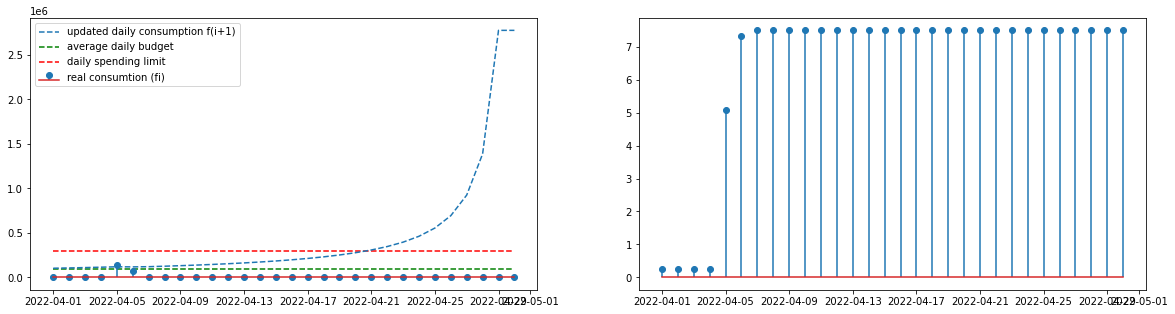

In [445]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,5))
ax1.plot(df.pay_created_dt,df.forecast_consumption,linestyle = '--', label = 'updated daily consumption f(i+1)')
ax1.hlines(y = avg_fi, xmin=min(df.pay_created_dt),xmax = max(df.pay_created_dt),linestyle = '--',color = 'g', label = 'average daily budget')
ax1.hlines(y = lim_sup, xmin=min(df.pay_created_dt),xmax = max(df.pay_created_dt), linestyle = '--',color = 'r',label = 'daily spending limit')
ax1.stem(df.pay_created_dt,df.AMOUNT, label = 'real consumtion (fi)')
ax1.legend(loc = 'upper left')

ax2.stem(df.pay_created_dt,df.ACC_AMOUNT*100/budget, label = 'consumtion until yesterday (F(i))')


In [ ]:
ax1.hlines(y = avg_fi, xmin=0,xmax = N,linestyle = '--',color = 'g', label = 'average daily budget')
ax1.hlines(y = lim_sup, xmin=0,xmax = N, linestyle = '--',color = 'r',label = 'daily spending limit')
ax1.stairs(df.AMOUNT, label = 'real consumtion (fi)')
ax1.legend(loc = 'upper left')

ax2.

In [425]:
yesterday = (pd.to_datetime('today') - timedelta(days = 1)).strftime('%Y-%m-%d')

In [426]:
df.loc[df.pay_created_dt==pd.to_datetime(yesterday)]

,pay_created_dt,AMOUNT,ACC_AMOUNT,forecast_consumption
5,2022-04-06,67000.0,219600.0,118641.666667


#### Relacion SENT vs Consumo.

In [243]:
%%time
#Al momento necesito es c = f(#push). No requiero el budget.
bop = '2022-01-01'
eop = '2022-04-05'
df = consumtion_expand(site = site, bop = bop,eop = eop)

# Hoy manny push.
q = QueryParamatrized(query_= 'HOW_MANNY_PUSH', query_param = {'bop':bop ,'eop':eop, 'site':site}, conf = conf)
sent = bq.execute_response(q)
sent['sent_date'] = pd.to_datetime(sent.sent_date)

#cupon variation.
q = QueryParamatrized(query_= 'CUPON_VARIATION', query_param = {'bop':bop ,'eop':eop, 'site':site}, conf = conf)
cupon_value = bq.execute_response(q)
cupon_value['pay_created_dt'] = pd.to_datetime(cupon_value.pay_created_dt)
cupon_value.sort_values(by = 'pay_created_dt', inplace= True)

#dataset
push_cost = df[['pay_created_dt','AMOUNT']].merge(sent,right_on = ['sent_date'],left_on =['pay_created_dt'],how = 'left')
push_cost = push_cost.merge(cupon_value[['pay_created_dt','mkt_cpn_amount']],on = 'pay_created_dt', how = 'left')
push_cost = push_cost[['pay_created_dt','AMOUNT','sent','mkt_cpn_amount']]
push_cost['day_of_week'] = [x.weekday() for x in push_cost.pay_created_dt]

push_cost.sent.fillna(0, inplace = True)
push_cost.mkt_cpn_amount.fillna(method = 'ffill', inplace=True)

2022-04-06 16:07:44 Excecuting NB_CONSUMTION with params: {'bop': '2022-01-01', 'eop': '2022-04-05', 'site': 'MLM'}
/usr/local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:445: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "
2022-04-06 16:07:46 Size of the dataframe (81, 3)
2022-04-06 16:07:46 Complet the dataframe (id is necessary) - new size: (95, 2)
2022-04-06 16:07:46 Total amount of consumtion is 4649432.6
2022-04-06 16:07:46 Excecuting HOW_MANNY_PUSH with params: {'bop': '2022-01-01', 'eop': '2022-04-05', 'site': 'MLM'}
2022-04-06 16:07:46 Excecuting CUPON_VARIATION with params: {'bop': '2022-01-01', 'eop': '2022-04-05', 'site': 'MLM'}


CPU times: user 92 ms, sys: 135 µs, total: 92.1 ms
Wall time: 3.42 s


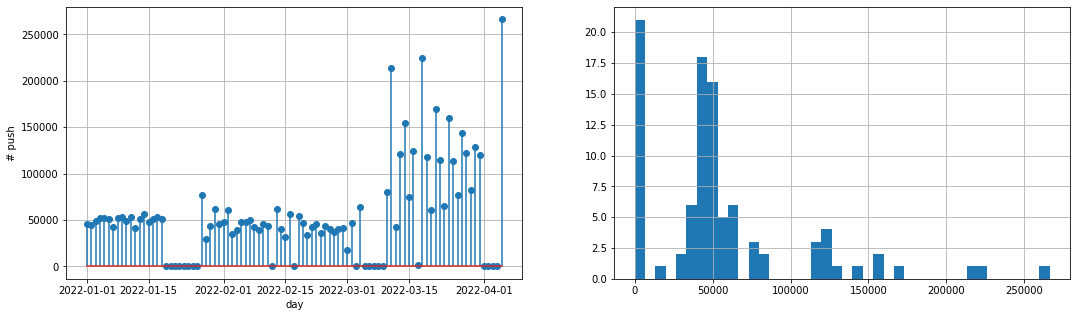

In [244]:
#Time series of push
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (18,5))
ax1.stem(push_cost.pay_created_dt,push_cost.sent)
ax1.set_ylabel('# push')
ax1.set_xlabel('day')
ax1.grid()
ax2.hist(push_cost.sent, bins = 40)
ax2.grid()

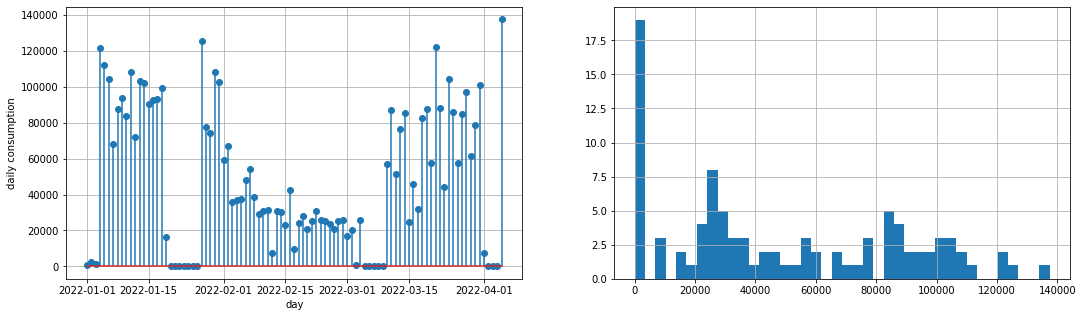

In [245]:
#Time series of push
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (18,5))
ax1.stem(push_cost.pay_created_dt,push_cost.AMOUNT)
ax1.set_ylabel('daily consumption')
ax1.set_xlabel('day')
ax1.grid()

ax2.hist(push_cost.AMOUNT, bins = 40)
ax2.grid()

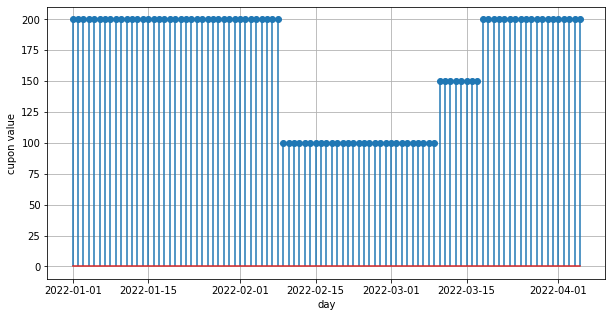

In [246]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.stem(push_cost.pay_created_dt,push_cost.mkt_cpn_amount)
ax.set_ylabel('cupon value')
ax.set_xlabel('day')
ax.grid()

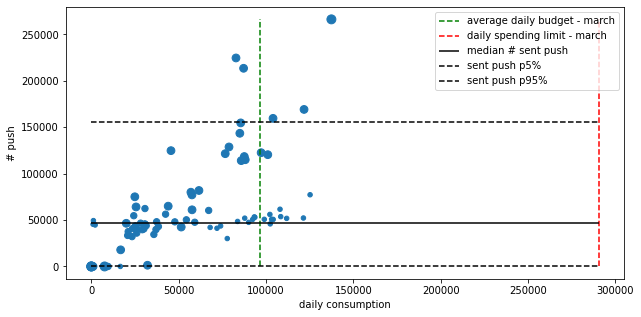

In [247]:
#Relation N push = f(daily cosnumtion)
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.scatter(push_cost.AMOUNT,push_cost.sent, s = [x.month*20 for x in push_cost.pay_created_dt])
ax.set_ylabel('# push')
ax.set_xlabel('daily consumption')
ax.vlines(x = avg_fi, ymin=0,ymax = np.max(push_cost.sent),linestyle = '--',color = 'g', label = 'average daily budget - march')
ax.vlines(x = lim_sup, ymin=0,ymax = np.max(push_cost.sent), linestyle = '--',color = 'r',label = 'daily spending limit - march')
ax.hlines(y = np.percentile(push_cost.sent,q = 50), xmin=0,xmax = lim_sup, linestyle = '-',color = 'k',label = 'median # sent push')

ax.hlines(y = np.percentile(push_cost.sent,q = 5), xmin=0,xmax = lim_sup, linestyle = '--',color = 'k',label = 'sent push p5%')
ax.hlines(y = np.percentile(push_cost.sent,q = 95), xmin=0,xmax = lim_sup, linestyle = '--',color = 'k',label = 'sent push p95%')

ax.legend()

In [261]:
#clean before traing
push_cost_filter = push_cost.copy()
push_cost_filter.loc[push_cost_filter.sent <= 5000,'sent'] = 0
push_cost_filter.loc[push_cost_filter.sent == 0,'AMOUNT'] = 0

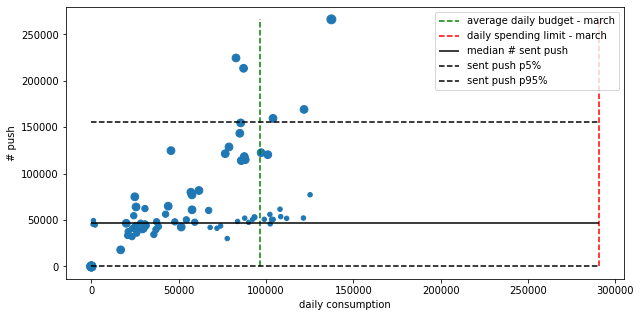

In [262]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.scatter(push_cost_filter.AMOUNT,push_cost_filter.sent, s = [x.month*20 for x in push_cost_filter.pay_created_dt])
ax.set_ylabel('# push')
ax.set_xlabel('daily consumption')
ax.vlines(x = avg_fi, ymin=0,ymax = np.max(push_cost_filter.sent),linestyle = '--',color = 'g', label = 'average daily budget - march')
ax.vlines(x = lim_sup, ymin=0,ymax = np.max(push_cost_filter.sent), linestyle = '--',color = 'r',label = 'daily spending limit - march')
ax.hlines(y = np.percentile(push_cost.sent,q = 50), xmin=0,xmax = lim_sup, linestyle = '-',color = 'k',label = 'median # sent push')

ax.hlines(y = np.percentile(push_cost.sent,q = 5), xmin=0,xmax = lim_sup, linestyle = '--',color = 'k',label = 'sent push p5%')
ax.hlines(y = np.percentile(push_cost.sent,q = 95), xmin=0,xmax = lim_sup, linestyle = '--',color = 'k',label = 'sent push p95%')

ax.legend()

In [384]:
#Get a model.
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression

target_var = 'sent'
time_var = 'pay_created_dt'
model_vars = set(push_cost_filter.columns) - set([target_var,time_var])
print(model_vars)

rb = RobustScaler()
push_cost_filter_ = pd.DataFrame(
    rb.fit_transform(
        push_cost_filter[model_vars]),
    columns=push_cost_filter[model_vars].columns
)

X_train, X_test, y_train, y_test = train_test_split(push_cost_filter_[model_vars],
                                                    push_cost_filter[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    test_size=0.33)

{'day_of_week', 'AMOUNT', 'mkt_cpn_amount'}


In [386]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [50,80, 90, 100, 110],
    'max_features': [1,2],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1,verbose = -1)
grid_search_rf.fit(X_train,y_train.ravel())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
     

In [387]:
param_grid = {
    'epsilon': [1.35,5,10,50],
    'alpha': [10**-4,10**-3,10**-2]
}

huber = HuberRegressor()
grid_search_huber = GridSearchCV(estimator = huber, param_grid = param_grid, cv = 3, n_jobs = -1,verbose = -1)
grid_search_huber.fit(X_train,y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  36 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=HuberRegressor(alpha=0.0001, epsilon=1.35,
                                      fit_intercept=True, max_iter=100,
                                      tol=1e-05, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'epsilon': [1.35, 5, 10, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=-1)

In [388]:
lm = LinearRegression()
lm.fit(X_train,y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [389]:
rf_sc = grid_search_rf.best_estimator_.score(X_test,y_test)
hu_sc = grid_search_huber.best_estimator_.score(X_test,y_test)
lm_sc = lm.score(X_test,y_test)
print(rf_sc)
print(hu_sc)
print(lm_sc)

0.11525282567018813
0.33328869086277857
0.30924364804594595


In [390]:
def mse(y_true,y_pred):
    return np.mean((y_true-y_pred)**2)

In [392]:
error = []
m = {'rf':grid_search_rf.best_estimator_,
     'hubber':grid_search_huber.best_estimator_,
     'lm': lm
    }

for model_type,model in m.items():       
    y_pred = model.predict(X_test)
    error.append(mse(y_test,y_pred))

In [393]:
error

[2151835426.3695593, 1621540091.6645331, 1680021176.9542677]

In [394]:
pd.to_pickle(grid_search_huber,'huber.pkl')
pd.to_pickle(rb,'scaler.pkl')

In [395]:
model = grid_search_huber.best_estimator_

In [397]:
y_pred = model.predict(X_test)

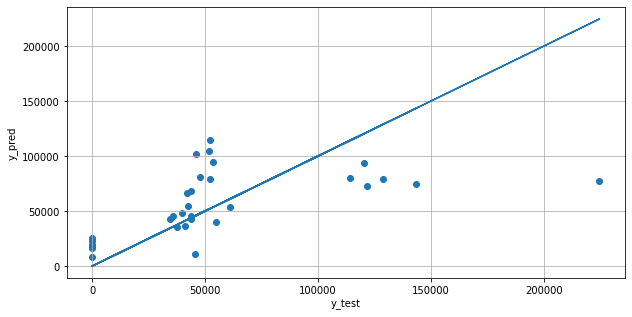

In [405]:
#Relation N push = f(daily cosnumtion)
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.scatter(y_test,y_pred, label = '(y_test,y_pred)')
ax.plot(y_test,y_test ,label = 'prefect prediction')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')
ax.grid()

In [399]:
X_test.columns

Index(['day_of_week', 'AMOUNT', 'mkt_cpn_amount'], dtype='object')

In [400]:
#Supongamos que necesito el limite superior dado un cupon de 200.
syntetic_data = pd.DataFrame({
    'day_of_week':[0,1,2,3,4,5,6], 
    'AMOUNT':[lim_sup,lim_sup,lim_sup,lim_sup,lim_sup,lim_sup,lim_sup], 
    'mkt_cpn_amount':[200,200,200,200,200,200,200]}
)
syntetic_data = pd.DataFrame(rb.transform(syntetic_data),columns=syntetic_data.columns)
syntetic_data

,day_of_week,AMOUNT,mkt_cpn_amount
0,-0.75,3.321792,0.0
1,-0.50,3.321792,0.0
2,-0.25,3.321792,0.0
3,0.00,3.321792,0.0
4,0.25,3.321792,0.0
5,0.50,3.321792,0.0
6,0.75,3.321792,0.0


In [403]:
cut = np.floor(lm.predict(syntetic_data))

In [404]:
cut

array([296421., 294251., 292080., 289910., 287739., 285568., 283398.])

(array([2., 1., 2., 3., 0., 1., 9., 3., 4., 2., 2., 1., 1., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([-73684.52819541, -63209.04316444, -52733.55813346, -42258.07310249,
        -31782.58807151, -21307.10304054, -10831.61800956,   -356.13297859,
         10119.35205239,  20594.83708336,  31070.32211434,  41545.80714532,
         52021.29217629,  62496.77720727,  72972.26223824,  83447.74726922,
         93923.23230019, 104398.71733117, 114874.20236214, 125349.68739312,
        135825.17242409]),
 <BarContainer object of 20 artists>)

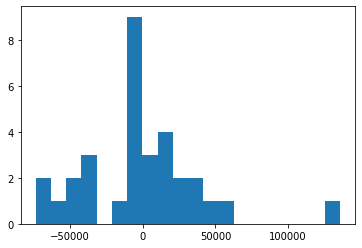

In [305]:
plt.hist(y_test - y_pred, bins = 20)

#### Check.

(F(t=i)+(n-i)*fi+1) = B

ACC_AMOUNT + fi+1*(n-1)

In [ ]:
(0 + 30*100000.0)/budget

In [ ]:
(16800.0 + 29*102868.96551724138)/budget

In [ ]:
(1497750.0+ 1502250.0)/budget

In [ ]:
backbone

In [ ]:
1.502250e+06+1576550.0

In [ ]:
#Ver como varia el budget de una campaña.
#Ver como varian los incrementales.
#Ver como ranquea el modelo y comparar con los incrementales reales.
#Ver si hay componenete estacional.

In [ ]:
budget = 3000000
eop_ = pd.to_datetime(eop) - timedelta(days = 1)
month_seq = pd.date_range(start = bop, end = eop_,freq = 'D')
fj = []
cj = []
Fj = []
N = ((pd.to_datetime(eop) - pd.to_datetime(bop)).days)
avg_fi = 3*budget/N
k = 0
for k, date in enumerate(month_seq) :
           
    if date == pd.to_datetime(bop):
        print('------start campain------')
        fi[k] = budget/N
        if  consumo_nb.loc[consumo_nb.pay_created_dt == date].empty:
            print(f'No consumption for {date}')
            Fi[k] = 0
            ci[k] = 0
        else:
            Fi[k] = consumo_nb.loc[consumo_nb.pay_created_dt == date].AMOUNT.values
            ci[k] = Fi[k]
        print('-------------------------')
    else:
         if  consumo_nb.loc[consumo_nb.pay_created_dt == date].empty:
            print(f'No consumption for {date}')
            I = (consumo_nb.pay_created_dt < date)&(~consumo_nb.ACC_AMOUNT.isnull())
            Fi[k] = consumo_nb.loc[I].ACC_AMOUNT.values[-1]
            ci = 0
        else:
            Fi = consumo_nb.loc[consumo_nb.pay_created_dt == date].ACC_AMOUNT.values
            ci = consumo_nb.loc[consumo_nb.pay_created_dt == date].AMOUNT.values
        
        
    fii = daily_consumption(budget = budget,
                            eop = eop,
                            bop = bop,
                            date_ = date,
                            Fi = Fi,
                            ci = ci,
                            fi = fi[k])
    k = k+1
    fi[k] =fii


#### Budget por campaña

In [ ]:
%%time
buget_variation = bq.execute_response(""" 
SELECT 
    push.CAMPAIGN_ID,
    budget.MKT_TOOL_ID,
    budget.BUDGET_LC,
    min(push.SENT_DATE) minDate_push_event,
    max(push.SENT_DATE) maxDate_push_event,
    min(budget.TIM_MONTH) minDate_budget
FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push 
LEFT JOIN meli-marketing.PUSH.LK_PUSH_BUDGET_COUPON budget 
ON push.CAMPAIGN_ID = budget.PUSH_CAMPAIGN_ID
AND budget.SIT_SITE_ID = 'MLB'
WHERE 1=1
AND BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%'
AND push.SENT_DATE BETWEEN DATE '2022-01-01' AND DATE '2022-03-30'
GROUP BY 1,2,3
ORDEr BY 2,3""")

In [ ]:
buget_variation.head(4)

#### Push events and model prediction.

In [ ]:
#model
storage.downlad_file(gs_source_path = 'gs://marketing-modelling/ML/NB/MLB/model/model_MLB.pkl', 
                     destination_file = 'old_model_nb.pkl')
model = pd.read_pickle('old_model_nb.pkl')

In [ ]:
%%time
q = pre.fun_query_apply('2022-01-05',PAIS ='MLB')
df = bq.execute_response(q)

In [ ]:
df.head()

In [ ]:
df['score'] = model.predict_proba(df)

In [ ]:
%%time
site = 'MLB'
date_intial = '2022-01-01'
date_end = '2022-03-30'
push_population = bq.execute_response(f"""
    WITH push as ( 
            SELECT 
                push.CUS_CUST_ID,
                push.SIT_SITE_ID,
                push.CAMPAIGN_ID,
                push.SENT_DATE, 
                push.EVENT_TYPE 
            FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push 
            WHERE BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%' 
                AND push.EVENT_TYPE in ('sent','control') 
                AND push.APP = 'mercadolibre'
                AND push.sit_site_id = '{site}' 
                AND push.SENT_DATE >= DATE '{date_intial}' AND push.SENT_DATE <= DATE '{date_end}' 
             ),
    orders_ as (
        SELECT 
            push.CUS_CUST_ID, 
            push.CAMPAIGN_ID,
            push.SENT_DATE, 
            push.EVENT_TYPE,
            orders.ORD_CREATED_DT,
            ROW_NUMBER() OVER (PARTITION BY push.CUS_CUST_ID ORDER BY orders.ORD_CREATED_DT) AS ORDERING_PURCHASE
        FROM push LEFT JOIN meli-bi-data.WHOWNER.BT_ORD_ORDERS orders
        ON push.CUS_CUST_ID = orders.ORD_BUYER.ID 
            AND push.sit_site_id = orders.SIT_SITE_ID 
            AND ORD_CLOSED_DT is not null
            AND orders.ord_status = 'paid' 
            AND orders.ORD_CLOSED_DT BETWEEN push.SENT_DATE AND push.SENT_DATE + 4 
            AND orders.ORD_CREATED_DT = push.SENT_DATE
        )

    SELECT 
        CUS_CUST_ID,
        CAMPAIGN_ID,
        SENT_DATE,
        EVENT_TYPE,
        CASE WHEN ORD_CREATED_DT is null THEN 0 ELSE 1 END AS CONVERSION
    FROM orders_
    WHERE ORDERING_PURCHASE = 1
    """ 
                                     )

In [ ]:
push_population.head(3)

In [ ]:
#model
storage.downlad_file(gs_source_path = 'gs://marketing-modelling/ML/NB/MLB/model/model_MLB.pkl', 
                     destination_file = 'old_model_nb.pkl')
model = pd.read_pickle('old_model_nb.pkl')

In [ ]:
model = pd.read_pickle('old_model_nb.pkl')

In [ ]:
model.predict_proba()

In [ ]:
a = 0 
B=100
delta = 12
for i in np.arange(2,30,1):
    a += 1/(i-1)

In [ ]:
(B-delta)*a